# Exercise 1 
### Group 2501:
* Bortolato Angela  |   matr. 2156562
* Fasiolo Giorgia   |   matr. 2159992
* Volpi Luca    |   matr. TO FILL!!
* Zara Miriam   |   matr. TO FILL!!

#### Imports

In [ ]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras_tuner 
from keras.optimizers import Adam, RMSprop, Nadam

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold

import pandas as pd

import tensorflow as tf

import random

plt.rcParams['font.size'] = 13

# set seeds for reproducibility
# Set seed for Python random
random.seed(42)
# Set seed for NumPy
np.random.seed(42)
# Set seed for TensorFlow
tf.random.set_seed(42)

%run useful.py

# training data
perc_train = 0.8

### Load, standardize and split data

In [21]:
# Keras works with numpy arrays: just use them from the start

TYPE=3
# data point size
L=8 
# span of each component
B=10
x = np.loadtxt(filename("data",L,TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",L,TYPE), delimiter=' ')
y = y.astype("int")
N = len(x)
# average and std.dev.
x_mean = np.mean(x,axis=0)
x_std  = np.std(x,axis=0)
# dim. of a sample
L = len(x[0])
N_train = int(perc_train * N)
print(f'data: {N}\ntrain: {N_train}')
#plot_data(x,y)


data: 2000
train: 1600


In [22]:
#print("before rescaling:\nmean value=", x_mean,"\nstd. dev.=",x_std)
def Standardize(x,m,s):
    """
    rescale each component using its mean and standard deviation
    """
    N = len(x)
    # assuming len(m)=len(s)=len(x[0])
    mm,ss = np.tile(m,(N,1)), np.tile(s,(N,1))
    return (x-mm)/ss
x = Standardize(x,x_mean,x_std)
print("after rescaling:\nmean value=", x.mean(axis=0),"\nstd. dev.=",x.std(axis=0))

after rescaling:
mean value= [ 2.53633226e-15  9.27924404e-16 -1.44884105e-15 -2.38371996e-15
 -2.85274582e-15 -2.02196593e-15 -1.09010023e-15 -1.53632662e-15] 
std. dev.= [1. 1. 1. 1. 1. 1. 1. 1.]


In [23]:
(x_train, y_train) = (x[0:N_train],y[0:N_train])
(x_valid, y_valid) = (x[N_train:],y[N_train:])
print("Train:",len(x_train),"\t Validation:",len(x_valid))

Train: 1600 	 Validation: 400


### Define the model and hyperparameters

In [24]:
def build_model(hp):
    
    chosen_activation = hp.Choice("activation", ["relu", "tanh", "sigmoid", "elu"])
    chosen_dropout = hp.Float("dropout_rate", min_value=0, max_value=0.2, step = 0.1)
    chosen_lr = hp.Float("learning_rate", min_value=1e-6, max_value=1e-1, sampling="log") 
     
    optimizers = {
        "adam": Adam(learning_rate=chosen_lr),
        "RMSprop": RMSprop(learning_rate=chosen_lr),
        "nadam": Nadam(learning_rate=chosen_lr),
    } 
    
    chosen_optimizer = hp.Choice("optimizer", ["adam", "RMSprop", "nadam"])        #other optimizers to try?


    model = Sequential()
    
    # input layer
    model.add( Dense(L, input_shape = (L, ), 
            # Tune the activation function to use.
            activation= chosen_activation,
        )
    )
    # first hidden
    model.add( Dense(20,
            activation=chosen_activation,
        )
    )
    model.add(Dropout(rate=chosen_dropout))
    # second hidden

    model.add( Dense(20,
            activation=chosen_activation,
        )
    )
    model.add(Dropout(rate=chosen_dropout))

    # third hidden
    model.add( Dense(20,
            activation=chosen_activation,
        )
    )
    model.add(Dropout(rate=chosen_dropout))

    # output layer
    model.add( Dense(1,
            activation="sigmoid",
        )
    )

    model.compile(
        optimizer=chosen_optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model


build_model(keras_tuner.HyperParameters())

c:\Users\angel\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<Sequential name=sequential_10, built=True>

#### **CHANGE MAX TRIALS, EXECUTIONS PER TRIAL AND EPOCHS !!!!!**
CHANGE VERBOSITY FOR NO TOO LONG OUTPUT

In [25]:
hp = keras_tuner.HyperParameters()


tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

tuner.search_space_summary()

Search space summary
Default search space size: 4
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid', 'elu'], 'ordered': False}
dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.2, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 1e-06, 'conditions': [], 'min_value': 1e-06, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'RMSprop', 'nadam'], 'ordered': False}


In [26]:
tuner.search(x_train, y_train, epochs=100, validation_data=(x_valid, y_valid), verbose=1)

Trial 10 Complete [00h 00m 27s]
val_accuracy: 0.75

Best val_accuracy So Far: 0.875
Total elapsed time: 00h 04m 07s


In [27]:
#OUTPUT TOO LONG !!

tuner.results_summary()

Results summary
Results in my_dir\helloworld
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 04 summary
Hyperparameters:
activation: tanh
dropout_rate: 0.0
learning_rate: 1.1998095163791455e-05
optimizer: RMSprop
Score: 0.875

Trial 00 summary
Hyperparameters:
activation: elu
dropout_rate: 0.2
learning_rate: 1.184314832206307e-06
optimizer: RMSprop
Score: 0.7925000190734863

Trial 01 summary
Hyperparameters:
activation: elu
dropout_rate: 0.1
learning_rate: 3.622825403642593e-06
optimizer: nadam
Score: 0.7649999856948853

Trial 07 summary
Hyperparameters:
activation: tanh
dropout_rate: 0.1
learning_rate: 1.1675400577345582e-05
optimizer: RMSprop
Score: 0.7549999952316284

Trial 06 summary
Hyperparameters:
activation: tanh
dropout_rate: 0.1
learning_rate: 6.276058653153576e-05
optimizer: RMSprop
Score: 0.75

Trial 09 summary
Hyperparameters:
activation: tanh
dropout_rate: 0.2
learning_rate: 0.0001014747627296842
optimizer: adam
Score: 0.75

Trial 05 summary


##### Compare best results of random search

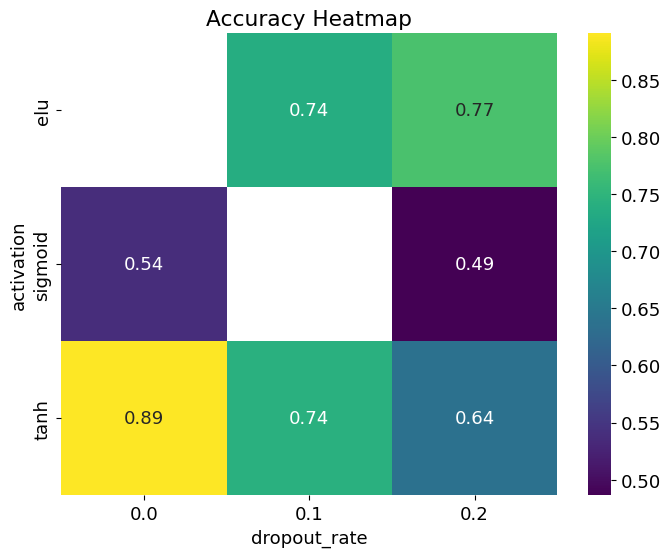

In [28]:
tuner_results = tuner.oracle.get_best_trials(num_trials=12)  # Return the best 12 trials based on objective metric

# Extract relevant data
results = [] 
for trial in tuner_results:
    trial_data = trial.hyperparameters.values # Retrieve hyperparameter values
    trial_data["accuracy"] = trial.metrics.get_best_value("accuracy")  # Retrieve accuracy evaluated at best epoch
    results.append(trial_data)

# Convert to DataFrame
df = pd.DataFrame(results)
df.head

import seaborn as sns

# Choose two hyperparameters for visualization
param_x = "activation"
param_y = "dropout_rate"

# Pivot table for heatmap
heatmap_data = df.pivot_table(index=param_x, columns=param_y, values="accuracy")

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="viridis")
plt.title("Accuracy Heatmap")
plt.show()

In [29]:
# Get the top 3 hyperparameters.  CAN CHANGE THE NUMBER OF BEST MODELS TO PLOT
best_hps = tuner.get_best_hyperparameters(3)

# Build the model with the best hp, iterate over best hp
history_list = []
for bhp in best_hps:
    model = build_model(bhp)
    history = model.fit(
        x_train, y_train,
        validation_data=(x_valid, y_valid),
        epochs=100,  
        batch_size=32,
        verbose=1
    )
    history_list.append(history)



Epoch 1/100


c:\Users\angel\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4832 - loss: 0.7300 - val_accuracy: 0.5375 - val_loss: 0.6901
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5103 - loss: 0.6937 - val_accuracy: 0.5550 - val_loss: 0.6810
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4944 - loss: 0.6918 - val_accuracy: 0.5500 - val_loss: 0.6752
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4994 - loss: 0.6898 - val_accuracy: 0.5600 - val_loss: 0.6765
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5336 - loss: 0.6863 - val_accuracy: 0.5375 - val_loss: 0.6743
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5063 - loss: 0.6850 - val_accuracy: 0.5500 - val_loss: 0.6775
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5349 - loss: 0.6845 - val_accuracy: 0.5400 - val_loss: 0.6766
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5070 - loss: 0.6876 - val_accuracy: 0.5575 - val_loss: 0.6

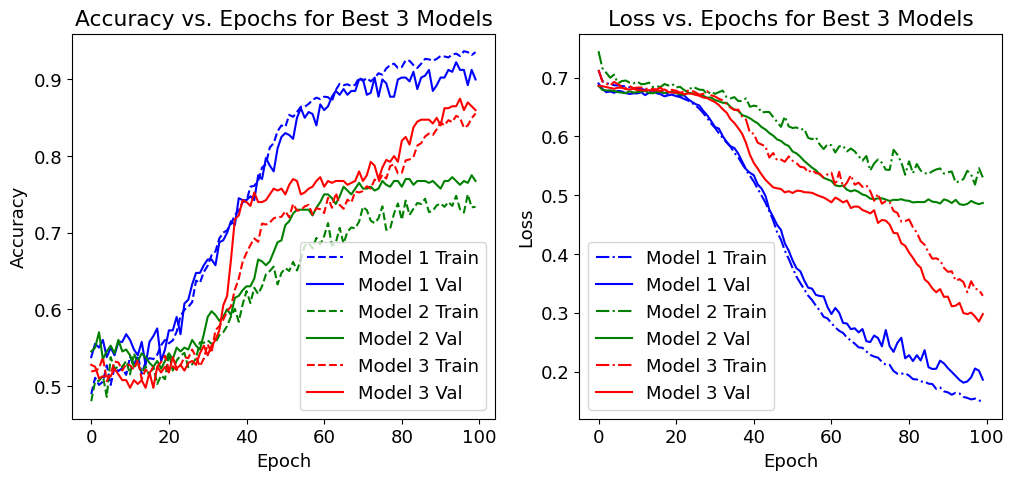

In [30]:
# Define colors for different models
colors = ["b", "g", "r"]  

fig, AX = plt.subplots(1, 2, figsize=(12, 5))

# Plot Accuracy
ax = AX[0]
for i, history in enumerate(history_list):
    ax.plot(history.history['accuracy'], label=f"Model {i+1} Train", c=colors[i], ls="--")
    ax.plot(history.history['val_accuracy'], label=f"Model {i+1} Val", c=colors[i])

ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs. Epochs for Best 3 Models")
ax.legend()

# Plot Loss
ax = AX[1]
for i, history in enumerate(history_list):
    ax.plot(history.history['loss'], label=f"Model {i+1} Train", c=colors[i], ls="-.")
    ax.plot(history.history['val_loss'], label=f"Model {i+1} Val", c=colors[i])

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss vs. Epochs for Best 3 Models")
ax.legend()

plt.show()


##### k-fold cross validation over the best models

cross validation (k fold): compute the STANDARD DEVIATION associated to the accuracy, across the folds. then you can make a meaningful comparison.


In [31]:
k = 5  

model_accuracies = {}

# Perform K-Fold Cross-Validation for each model
for i, bhp in enumerate(best_hps):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)  # KFold object
    fold_accuracies = []
    model=build_model(bhp)

    for train_idx, test_idx in kfold.split(x_train, y_train):  # Splitting indices
        X_train_fold, X_test_fold = x_train[train_idx], x_train[test_idx]
        y_train_fold, y_test_fold = y_train[train_idx], y_train[test_idx]

        model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=32, verbose=0)

        _, accuracy = model.evaluate(X_test_fold, y_test_fold, verbose=0)
        fold_accuracies.append(accuracy)

    # Store accuracy results
    mean_accuracy = np.mean(fold_accuracies)
    std_accuracy = np.std(fold_accuracies)
    model_accuracies[f"Model {i+1}"] = (mean_accuracy, std_accuracy)

    print(f"Model {i+1} -> Mean Accuracy: {mean_accuracy:.4f}, Std Dev: {std_accuracy:.4f}")



Model 1 -> Mean Accuracy: 0.9056, Std Dev: 0.0774
Model 2 -> Mean Accuracy: 0.8263, Std Dev: 0.1358
Model 3 -> Mean Accuracy: 0.9087, Std Dev: 0.1014


319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step


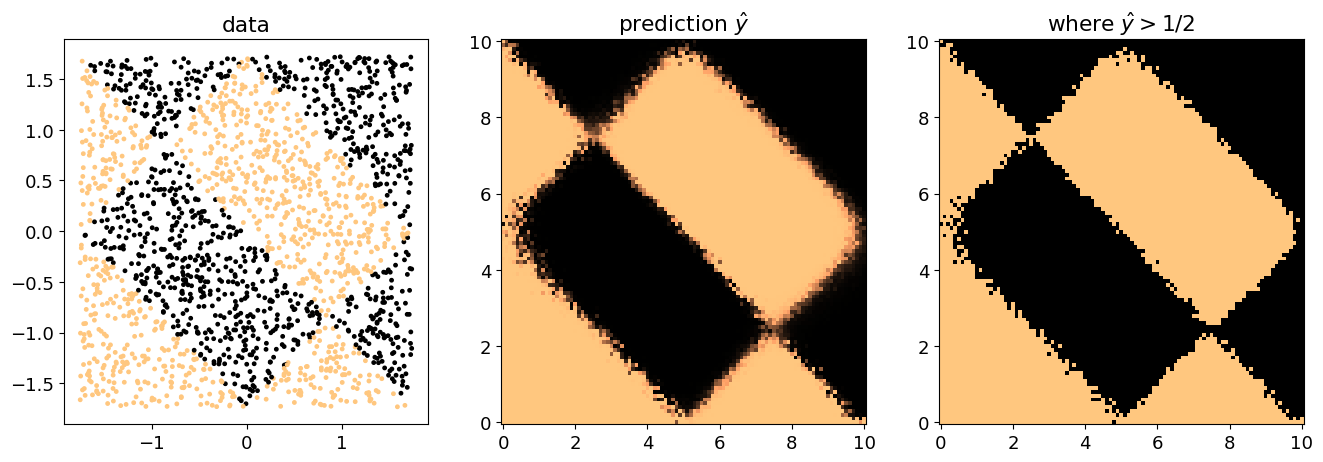

remember: these ar 2 out of L=8 dimensions, of which L-2 contain random noise


In [32]:
dX = .1
X1 = np.arange(0,10+dX, dX)
LG = len(X1)
X, Y = np.meshgrid(X1, X1)
allXY = np.reshape((np.array((X,Y)).T),(LG**2,2))
grid = np.random.rand(LG**2,L)*B
grid[:,:2] = allXY
grid_r=Standardize(grid,x_mean,x_std)

pred = model.predict(grid_r)

fig,AX=plt.subplots(1,3,figsize=(16,5.))
ax=AX[0]
ax.scatter(x[:,0],x[:,1],c=y,s=6)
ax.set_title("data")
ax=AX[1]
ax.pcolormesh(X1,X1,pred.reshape((LG, LG)))
ax.set_title("prediction $\\hat y$")
ax=AX[2]
pred01=np.copy(pred)
pred01[pred>0.5]=1
pred01[pred<=0.5]=0
ax.pcolormesh(X1,X1,pred01.reshape((LG, LG)))
ax.set_title("where $\\hat y > 1/2$")
plt.show()
print(f"remember: these ar 2 out of L={L} dimensions, of which L-2 contain random noise")

### Data augmentation


AUGMENTATION:

small displacement and give it the same class as the original one. 
if done with moderation, it increases accuracy of the nn. if you do it too much, you risk. 


In [33]:
red_rate = [0.75, 0.5, 0.25]
aug_rate = [2, 4, 6]

best_model=build_model(best_hps[0])


# To store performance results
results = {'reduced': [], 'augmented': []}

for red, aug in zip(red_rate, aug_rate):
    # Reduction
    n_reduced = int(red * len(x_train))
    idx = np.arange(len(x_train))
    idx_reduced = np.random.choice(idx, n_reduced, replace=False)
    
    x_train_reduced = x_train[idx_reduced]
    y_train_reduced = y_train[idx_reduced]

    # Fit model with reduced data
    fit_reduced = best_model.fit(x_train_reduced, y_train_reduced,
                                 epochs=100, batch_size=50,
                                 validation_data=(x_valid, y_valid),
                                 verbose=0)
    
    # Evaluate performance with reduced data
    loss, accuracy = best_model.evaluate(x_valid, y_valid, verbose=0)
    results['reduced'].append({'rate': red, 'accuracy': accuracy})

    # Augmentation
    n_augmented = aug * len(x_train)
    
    x_train_augmented = np.concatenate([x_train] * aug, axis=0)
    y_train_augmented = np.concatenate([y_train] * aug, axis=0)

    noise = np.random.normal(0, 1e-2, x_train_augmented.shape)
    x_train_augmented = x_train_augmented + noise


    # Fit model with augmented data
    fit_augmented = best_model.fit(x_train_augmented, y_train_augmented,
                                   epochs=100, batch_size=50,
                                   validation_data=(x_valid, y_valid),
                                   verbose=0)
    
    # Evaluate performance with augmented data
    loss, accuracy = best_model.evaluate(x_valid, y_valid, verbose=0)
    results['augmented'].append({'rate': aug, 'accuracy': accuracy})

# Display results
for key, value in results.items():
    print(f"\nPerformance with {key} data:")
    for v in value:
        print(f"Rate: {v['rate']}, Accuracy: {v['accuracy']:.4f}")

    


Performance with reduced data:
Rate: 0.75, Accuracy: 0.7500
Rate: 0.5, Accuracy: 0.9200
Rate: 0.25, Accuracy: 0.9325

Performance with augmented data:
Rate: 2, Accuracy: 0.9075
Rate: 4, Accuracy: 0.9250
Rate: 6, Accuracy: 0.9325


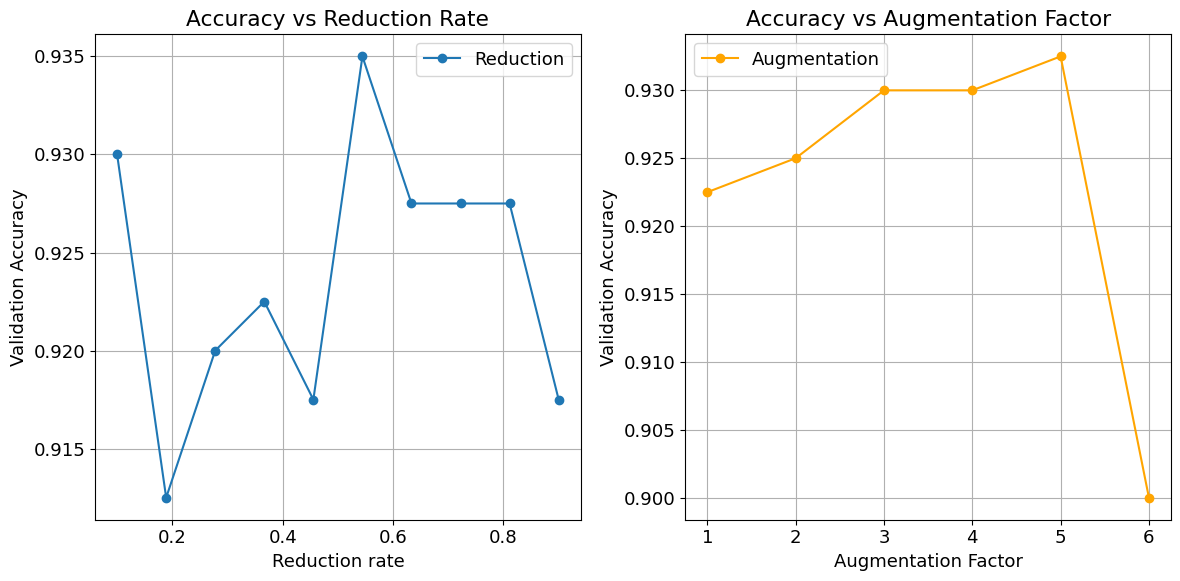

In [34]:
# Try now to do the same but more gradually 

# Define finer steps for reduction and augmentation rates
reduction = np.linspace(0.1, 0.9, 10)  # 10 steps from 10% to 100% of data
augmentation = np.arange(1, 7, 1)         # Multiplication factors from 1 to 6

# Store results
red_accuracies = []
aug_accuracies = []

nepoch = 100

# Loop for reduction rates
for red in reduction:
    n_reduced = int((1 - red) * len(x_train))
    idx = np.arange(len(x_train))
    idx_reduced = np.random.choice(idx, n_reduced, replace=False)
    
    x_train_reduced = x_train[idx_reduced]
    y_train_reduced = y_train[idx_reduced]
    
    # Train on reduced data
    fit_reduced = best_model.fit(x_train_reduced, y_train_reduced,
                                 epochs=nepoch, batch_size=50,
                                 validation_data=(x_valid, y_valid),
                                 verbose=0)
    
    # Evaluate and store accuracy
    _, accuracy = best_model.evaluate(x_valid, y_valid, verbose=0)
    red_accuracies.append(accuracy)

# Loop for augmentation rates
for aug in augmentation:
    noise = np.random.normal(0, 1e-2, x_train.shape)
    x_train_augmented = np.concatenate([x_train] * aug, axis=0)
    y_train_augmented = np.concatenate([y_train] * aug, axis=0)

    noise = np.random.normal(0, 1e-2, x_train_augmented.shape)
    x_train_augmented = x_train_augmented + noise
    
    # Train on augmented data
    fit_augmented = best_model.fit(x_train_augmented, y_train_augmented,
                                   epochs=nepoch, batch_size=50,
                                   validation_data=(x_valid, y_valid),
                                   verbose=0)
    
    # Evaluate and store accuracy
    _, accuracy = best_model.evaluate(x_valid, y_valid, verbose=0)
    aug_accuracies.append(accuracy)

# Plotting
plt.figure(figsize=(12, 6))

# Plot for reduction
plt.subplot(1, 2, 1)
plt.plot(1 - reduction, red_accuracies, marker='o', label='Reduction')
plt.xlabel('Reduction rate')
plt.ylabel('Validation Accuracy')
plt.title('Accuracy vs Reduction Rate')
plt.grid(True)
plt.legend()

# Plot for augmentation
plt.subplot(1, 2, 2)
plt.plot(augmentation, aug_accuracies, marker='o', label='Augmentation', color='orange')
plt.xlabel('Augmentation Factor')
plt.ylabel('Validation Accuracy')
plt.title('Accuracy vs Augmentation Factor')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Try now augmentation by augmenting with half step points